In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from qulacs import QuantumCircuit
from qulacs.gate import X
from qulacs import QuantumState
from qulacs.circuit import QuantumCircuitOptimizer

import scipy as sc

from src.custom_qulacs_gates import RXX, RYY
from src.Chain import Chain
from src.Qulacs_CPQAOA import Qulacs_CPQAOA


In [2]:
S = 10
N_min, N_max = 4, 15
L = 6

In [85]:
native_res = {N: [] for N in range(N_min,N_max+1)}
decomposed_res = {N: [] for N in range(N_min,N_max+1)}
for N in range(N_min,N_max+1):
    pairs = Chain(N).get_NNN_indices()
    initialization_strategy = [0 if i%2 == 0 else 1 for i in range(N)]
    for seed in range(S):
        angles = np.random.uniform(-2*np.pi, 2*np.pi, L*len(pairs))
        
        state = QuantumState(N)
        qcircuit = QuantumCircuit(N)
        # Initial state: 'k' excitations
        for qubit_idx in initialization_strategy:
            qcircuit.add_gate(X(index=qubit_idx))
        # Layered Ansatz
        angle_counter = 0
        for layer in range(L):
            for qubit_i, qubit_j in pairs:
                theta = angles[angle_counter]
                RXX(circuit=qcircuit, angle=theta, qubit_1=qubit_i, qubit_2=qubit_j, use_native=True)
                RYY(circuit=qcircuit, angle=theta, qubit_1=qubit_i, qubit_2=qubit_j, use_native=True)
                angle_counter += 1  
        start_native = time()
        qcircuit.update_quantum_state(state)
        state_vector = state.get_vector()
        end_native = time()
        native_res[N].append(end_native - start_native)
        
        
        state = QuantumState(N)
        qcircuit = QuantumCircuit(N)
        # Initial state: 'k' excitations
        for qubit_idx in initialization_strategy:
            qcircuit.add_gate(X(index=qubit_idx))
        # Layered Ansatz
        angle_counter = 0
        for layer in range(L):
            for qubit_i, qubit_j in pairs:
                theta = angles[angle_counter]
                RXX(circuit=qcircuit, angle=theta, qubit_1=qubit_i, qubit_2=qubit_j, use_native=False)
                RYY(circuit=qcircuit, angle=theta, qubit_1=qubit_i, qubit_2=qubit_j, use_native=False)
                angle_counter += 1
                
        start_decomposed = time()
        qcircuit.update_quantum_state(state)
        state_vector = state.get_vector()
        end_decomposed = time()
        decomposed_res[N].append(end_decomposed-start_decomposed)


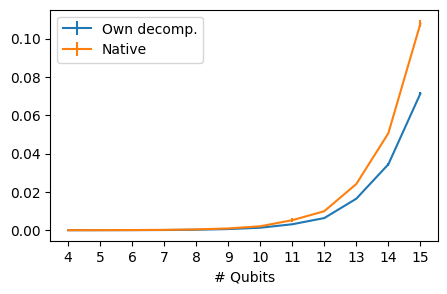

In [86]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
N_vals = [N for N in range(N_min,N_max+1)]
ax.errorbar(N_vals, 
            [np.mean(decomposed_res[N]) for N in N_vals],
            [np.std(decomposed_res[N]) for N in N_vals], label = 'Own decomp.')

ax.errorbar(N_vals, 
            [np.mean(native_res[N]) for N in N_vals],
            [np.std(native_res[N]) for N in N_vals], label = 'Native')
ax.set_xticks(N_vals)
ax.set_xlabel('# Qubits')
ax.legend()
plt.show()

In [87]:
un_optimized_res = {N: [] for N in range(N_min,N_max+1)}
block_1_res = {N: [] for N in range(N_min,N_max+1)}
block_2_res = {N: [] for N in range(N_min,N_max+1)}
for N in range(N_min,N_max+1):
    pairs = Chain(N).get_NNN_indices()
    initialization_strategy = [0 if i%2 == 0 else 1 for i in range(N)]
    for seed in range(S):
        opt = QuantumCircuitOptimizer()
        
        np.random.seed(seed)
        angles = np.random.uniform(-2*np.pi, 2*np.pi, L*len(pairs))
        
        state = QuantumState(N)
        qcircuit = QuantumCircuit(N)
        # Initial state: 'k' excitations
        for qubit_idx in initialization_strategy:
            qcircuit.add_gate(X(index=qubit_idx))
        # Layered Ansatz
        angle_counter = 0
        for layer in range(L):
            for qubit_i, qubit_j in pairs:
                theta = angles[angle_counter]
                RXX(circuit=qcircuit, angle=theta, qubit_1=qubit_i, qubit_2=qubit_j, use_native=False)
                RYY(circuit=qcircuit, angle=theta, qubit_1=qubit_i, qubit_2=qubit_j, use_native=False)
                angle_counter += 1  
        start_un_optimized = time()
        qcircuit.update_quantum_state(state)
        state_vector = state.get_vector()
        end_un_optimized = time()
        un_optimized_res[N].append(end_un_optimized - end_un_optimized)
        
        
        
        
        state = QuantumState(N)
        qcircuit = QuantumCircuit(N)
        # Initial state: 'k' excitations
        for qubit_idx in initialization_strategy:
            qcircuit.add_gate(X(index=qubit_idx))
        # Layered Ansatz
        angle_counter = 0
        for layer in range(L):
            for qubit_i, qubit_j in pairs:
                theta = angles[angle_counter]
                RXX(circuit=qcircuit, angle=theta, qubit_1=qubit_i, qubit_2=qubit_j, use_native=False)
                RYY(circuit=qcircuit, angle=theta, qubit_1=qubit_i, qubit_2=qubit_j, use_native=False)
                angle_counter += 1
        # The maximum quantum gate size allowed to be created
        max_block_size = 1
        opt.optimize(qcircuit, max_block_size)
        start_block_1 = time()
        qcircuit.update_quantum_state(state)
        state_vector = state.get_vector()
        end_block_1 = time()
        block_1_res[N].append(end_block_1-start_block_1)
        
        
        opt = QuantumCircuitOptimizer()
        
        state = QuantumState(N)
        qcircuit = QuantumCircuit(N)
        # Initial state: 'k' excitations
        for qubit_idx in initialization_strategy:
            qcircuit.add_gate(X(index=qubit_idx))
        # Layered Ansatz
        angle_counter = 0
        for layer in range(L):
            for qubit_i, qubit_j in pairs:
                theta = angles[angle_counter]
                RXX(circuit=qcircuit, angle=theta, qubit_1=qubit_i, qubit_2=qubit_j, use_native=False)
                RYY(circuit=qcircuit, angle=theta, qubit_1=qubit_i, qubit_2=qubit_j, use_native=False)
                angle_counter += 1
        # The maximum quantum gate size allowed to be created
        max_block_size = 2
        opt.optimize(qcircuit, max_block_size)
        start_block_2 = time()
        qcircuit.update_quantum_state(state)
        state_vector = state.get_vector()
        end_block_2 = time()
        block_2_res[N].append(end_block_2-start_block_2)


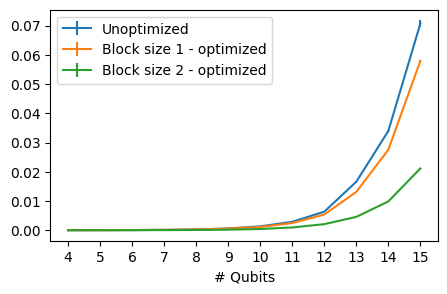

In [88]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
N_vals = [N for N in range(N_min,N_max+1)]
ax.errorbar(N_vals, 
            [np.mean(un_optimized_res[N]) for N in N_vals],
            [np.std(un_optimized_res[N]) for N in N_vals], label = 'Unoptimized')

ax.errorbar(N_vals, 
            [np.mean(block_1_res[N]) for N in N_vals],
            [np.std(block_1_res[N]) for N in N_vals], label = 'Block size 1 - optimized')

ax.errorbar(N_vals, 
            [np.mean(block_2_res[N]) for N in N_vals],
            [np.std(block_2_res[N]) for N in N_vals], label = 'Block size 2 - optimized')
ax.set_xticks(N_vals)
ax.set_xlabel('# Qubits')
ax.legend()
plt.show()

In [4]:
S = 10
N_min, N_max = 4, 15
L = 6
max_iter = 25

In [ ]:
opt_circuit_res = {N: [] for N in range(N_min, N_max+1)}
normal_circuit_res = {N: [] for N in range(N_min, N_max+1)}
for seed in range(S):
    np.random.seed(seed)
    for N in range(N_min, N_max+1):
        k = N // 2
        topology = Chain(N_qubits=N)
        topology.set_initialization_strategy(strategy=np.array([0 if i % 2 == 0 else 1 for i in range(N)]))
        angles = np.random.uniform(-2 * np.pi, 2 * np.pi, L * len(topology.get_NN_indices()))
        Q = np.random.uniform(0, 1, (N, N))
        Q = (Q + Q.T) / 2.0
        
        Qulacs_ansatz_1 = Qulacs_CPQAOA(N_qubits=N,
                                      cardinality=k,
                                      layers=L,
                                      topology=topology,
                                      QUBO_matrix=Q,
                                      use_parametric_circuit_opt=True,
                                      approximate_hamiltonian=True)
        Qulacs_ansatz_1_start_time = time()
        Qulacs_ansatz_1_sim = sc.optimize.minimize(fun=Qulacs_ansatz_1.get_cost, 
                                  x0=angles,
                                  method='COBYLA',
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        Qulacs_ansatz_1_stop_time = time()
        if Qulacs_ansatz_1_sim['nfev'] > 0:
            time_pr_iter = (Qulacs_ansatz_1_stop_time-Qulacs_ansatz_1_start_time) / Qulacs_ansatz_1_sim['nfev']
            opt_circuit_res[N].append(time_pr_iter)
            
            
            
            
        Qulacs_ansatz_2 = Qulacs_CPQAOA(N_qubits=N,
                                      cardinality=k,
                                      layers=L,
                                      topology=topology,
                                      QUBO_matrix=Q,
                                      use_parametric_circuit_opt=False,
                                      approximate_hamiltonian=True)
        Qulacs_ansatz_2_start_time = time()
        Qulacs_ansatz_2_sim = sc.optimize.minimize(fun=Qulacs_ansatz_2.get_cost, 
                                  x0=angles,
                                  method='COBYLA',
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        Qulacs_ansatz_2_stop_time = time()
        if Qulacs_ansatz_2_sim['nfev'] > 0:
            time_pr_iter = (Qulacs_ansatz_2_stop_time-Qulacs_ansatz_2_start_time) / Qulacs_ansatz_2_sim['nfev']
            normal_circuit_res[N].append(time_pr_iter)

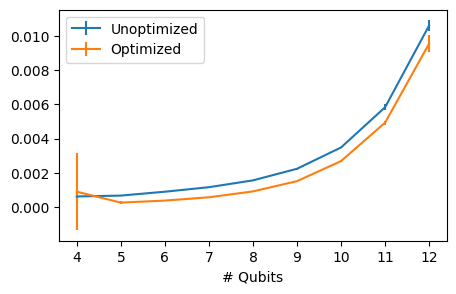

In [4]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
N_vals = [N for N in range(N_min,N_max+1)]
ax.errorbar(N_vals, 
            [np.mean(normal_circuit_res[N]) for N in N_vals],
            [np.std(normal_circuit_res[N]) for N in N_vals], label = 'Unoptimized')

ax.errorbar(N_vals, 
            [np.mean(opt_circuit_res[N]) for N in N_vals],
            [np.std(opt_circuit_res[N]) for N in N_vals], label = 'Optimized')

ax.set_xticks(N_vals)
ax.set_xlabel('# Qubits')
ax.legend()
plt.show()